<p id="part0"></p>

<p style="font-family: Arials; line-height: 1.5; font-size: 24px; font-weight: bold; letter-spacing: 2px; text-align: center; color: #6495ED"><br>
Breast Cancer Risk Prediction <br> Final Datapipeline</p>
<br>

<p style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: #808080; line-height:1">TABLE OF CONTENT</p>

<p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #808080; line-height:1"><a href="#0." style="color:#808080">0. Importing Modules</a></p>

<p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #808080; line-height:1"><a href="#1." style="color:#808080">1. Data Gather, Preparation and Train-Test Split</a></p>

<p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #808080; line-height:1"><a href="#2." style="color:#808080">2. Prediction and Metrics</a></p>

<p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #808080; line-height:1"><a href="#3." style="color:#808080">3. Model Interpretation</a></p>


<p id="0."></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: #6495ED">0. Importing Modules</span>
<hr style="height: 0.5px; border: 0; background-color: #e24a33">

In [87]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pickle
plt.style.use('seaborn')

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier # pipeline builder can handle

from sklearn.tree import plot_tree
from pdpbox import pdp

<p id="1."></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: #6495ED">1. Data Gather, Preparation and Train-Test Split</span>
<hr style="height: 0.5px; border: 0; background-color: #e24a33">

In [88]:
def clean_data(df):
    """Returns cleaned DataFrame.
    
    Correcting typos
    Transform datatypes from object to category
    Drop column 'Grade'

    Args: 
        df (pd.DataFrame) : uncleaned DataFrame
        
    Returns:
        df  (pd.DataFrame) : cleaned DataFrame
    """
    # correcting typos
    df = df.rename(columns={'T Stage ':'T Stage'})
    df = df.rename(columns={'Reginol Node Positive': 'Regional Node Positive'})

    # remapping target column
    df.loc[:,'Status_encoded'] = df.loc[:,'Status'].map({'Alive':0, 'Dead':1})

    # changing dtypes of columns as needed
    dtypes_columns = {'Age' : 'int64',
        'Race' : 'category',
        'Marital Status' : 'category',
        'T Stage' : 'category', 
        'N Stage' : 'category',
        '6th Stage' : 'category',
        'differentiate' : 'category',
        'Grade' : 'category',
        'A Stage' : 'category', 
        'Tumor Size' : 'int64',
        'Estrogen Status' : 'category',
        'Progesterone Status' : 'category',
        'Regional Node Examined' : 'int64',
        'Regional Node Positive' : 'int64',
        'Survival Months' : 'int64',
        'Status' : 'category',
        'Status_encoded' : 'int64',
        'Node_Exam_Pos_Rate': 'float64',
        'Estrogen_Progesteron_Status': 'category'}
    df = df.astype(dtypes_columns)

    # drop 'Grade' columns because the information is the same as in the 'differentiate' column
    df.drop('Status', axis=1, inplace=True)
    df.drop('Grade', axis=1, inplace=True)

    return df

In [89]:
def feature_engineering(df):
    """Add new Features to Dataframe.
    
    Add features Node_Exam_Pos_Rate and Estrogen Status
       
    Args:
        df (pd.DataFrame): Dataframe
        ohe_transformer: The fitted ohe_transformer
    
    Returns:
        (pd.DataFrame) : Dataframe with new Features
    """ 

    # ['Node_Examined_Pos_Rate']: Positive Nodes per Examined Nodes
    df.loc[:,'Node_Exam_Pos_Rate'] = df.loc[:,'Reginol Node Positive']/df.loc[:,'Regional Node Examined']

    #['Progesteron_Estrogen_Status']: Positive status if status of both receptors is positive
    mask = (df['Estrogen Status'] == 'Positive') | (df['Progesterone Status'] == 'Positive')
    conditions = [mask, ~mask]
    values = ['Positive', 'Negative']
    df['Estrogen_Progesteron_Status'] = np.select(conditions, values)

    return df

In [90]:
# loading functions and model
model = pickle.load(open('pipeline_rfc.p', 'rb'))

In [91]:
# data gathering
df = pd.read_csv('Breast_Cancer.csv', delimiter=',')

In [92]:
# preparations

# adding two new features
df = feature_engineering(df)

# clean dataframe
df_clean = clean_data(df)
df_clean.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Node_Exam_Pos_Rate,Estrogen_Progesteron_Status,Status_encoded
0,68,White,Married,T1,N1,IIA,Poorly differentiated,Regional,4,Positive,Positive,24,1,60,0.041667,Positive,0
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,Regional,35,Positive,Positive,14,5,62,0.357143,Positive,0
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,Regional,63,Positive,Positive,14,7,75,0.500000,Positive,0
3,58,White,Married,T1,N1,IIA,Poorly differentiated,Regional,18,Positive,Positive,2,1,84,0.500000,Positive,0
4,47,White,Married,T2,N1,IIB,Poorly differentiated,Regional,41,Positive,Positive,3,1,50,0.333333,Positive,0


In [93]:
# creating target and features 
target = df_clean.loc[:,'Status_encoded']
#features = df.drop('Status', axis=1)
features = df_clean.drop('Status_encoded', axis=1)

# train and test split
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=42,
                                                                            test_size=0.1)

<p id="2."></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: #6495ED">2. Prediction and Metrics</span>
<hr style="height: 0.5px; border: 0; background-color: #e24a33">

In [94]:
final_results = []

In [95]:
cat_cols = ['Race', 'Marital Status', 'Estrogen Status', 'Progesterone Status', 'Estrogen_Progesteron_Status']
ord_cols = ['T Stage', 'N Stage', '6th Stage', 'differentiate', 'A Stage']
num_cols = [col for col in features_train.select_dtypes(include=["int64","float64"])]

In [96]:
# the model
from sklearn.preprocessing import PolynomialFeatures


model = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                              ('cat_transformer', OneHotEncoder(drop='if_binary'), cat_cols), 
                              ('ord_transformer', OrdinalEncoder(), ord_cols)
                         ], remainder='passthrough')),
                         ('model', RandomForestClassifier(max_depth=21, min_samples_leaf=2, n_estimators=172, class_weight='balanced', random_state=42, n_jobs=-1))])

model_2 = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ("poly", PolynomialFeatures(degree=2, interaction_only=False, include_bias=False) ),
                    ('classifier', RandomForestClassifier(max_depth=18, max_features=6, min_samples_leaf=4, min_samples_split=2, 
                                                          n_estimators=130, class_weight="balanced", random_state=42))])

In [97]:
# train the model
model_2.fit(features_train, target_train)

#predict
target_pred = model_2.predict(features_test)

#save
scores = {'accuracy': accuracy_score(target_test, target_pred) * 100,
          'precision': precision_score(target_test, target_pred) * 100,
          'recall': recall_score(target_test, target_pred) * 100,
          'f1': f1_score(target_test, target_pred) * 100,
        }
final_results.append(scores)
    
#show results
pd.DataFrame(final_results)

,accuracy,precision,recall,f1
0,91.563275,80.0,68.571429,73.846154


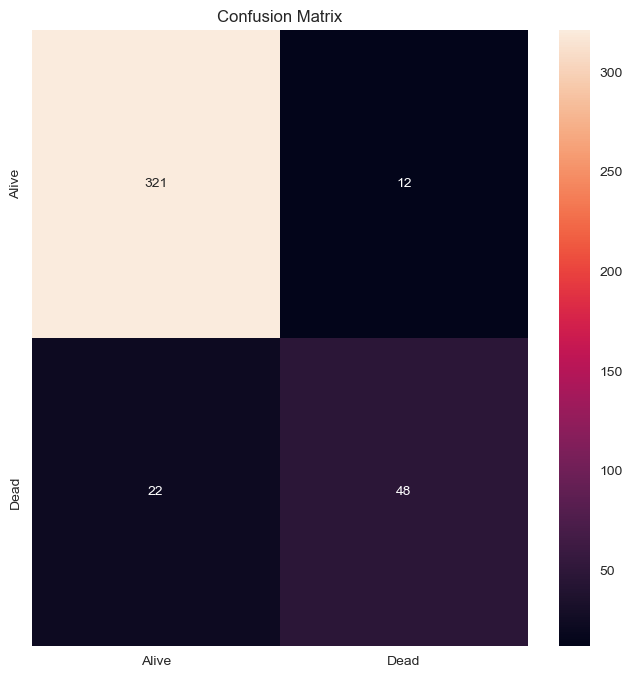

In [98]:
# confusion matrix
labels = ['Alive', 'Dead']
cm = confusion_matrix(target_test, target_pred)
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('Confusion Matrix')
plt.show()

In [99]:
# report
report = classification_report(target_test, target_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       333
           1       0.80      0.69      0.74        70

    accuracy                           0.92       403
   macro avg       0.87      0.82      0.84       403
weighted avg       0.91      0.92      0.91       403



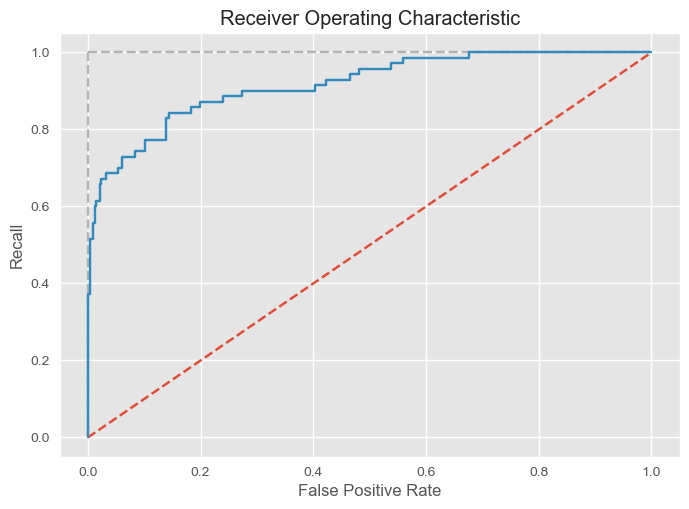

In [100]:
# print roc-curve

# create DataFrame with one column named prediction
df_pred_test = pd.DataFrame(target_pred, columns=['prediction'])

# predict probabilities and add them as new column
df_pred_test.loc[:, 'probability'] = model_2.predict_proba(features_test)[:, 1]  

# calculate roc-curve
from sklearn.metrics import roc_curve

false_positive_rate, recall, threshold = roc_curve(target_test, df_pred_test.loc[:, 'probability']) 

# plotting
plt.style.use('ggplot')

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--")  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall)

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall");

<p id="3."></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; color: #6495ED">3. Model Interpretation</span>
<hr style="height: 0.5px; border: 0; background-color: #e24a33">

In [101]:
model.fit(features_train, target_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_transformer',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Race', 'Marital Status',
                                                   'Estrogen Status',
                                                   'Progesterone Status',
                                                   'Estrogen_Progesteron_Status']),
                                                 ('ord_transformer',
                                                  OrdinalEncoder(),
                                                  ['T Stage', 'N Stage',
                                                   '6th Stage', 'differentiate',
                                                   'A Stage'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=21,
                                        min_samples_leaf=2, n_estimators=172,
                                        n_jobs=-1, random_state=42))])

In [102]:
feature_importance = pd.Series(data=model.named_steps['model'].feature_importances_, index=model.named_steps['preprocessing'].get_feature_names_out())
feature_importance = feature_importance.sort_values(ascending=False).head(12)
feature_importance

remainder__Survival Months                       0.378360
remainder__Node_Exam_Pos_Rate                    0.108415
remainder__Age                                   0.090748
remainder__Tumor Size                            0.081066
remainder__Regional Node Examined                0.070808
remainder__Regional Node Positive                0.057703
ord_transformer__6th Stage                       0.033487
ord_transformer__differentiate                   0.029788
ord_transformer__N Stage                         0.029461
ord_transformer__T Stage                         0.021043
cat_transformer__Progesterone Status_Positive    0.019185
cat_transformer__Marital Status_Married          0.013950
dtype: float64

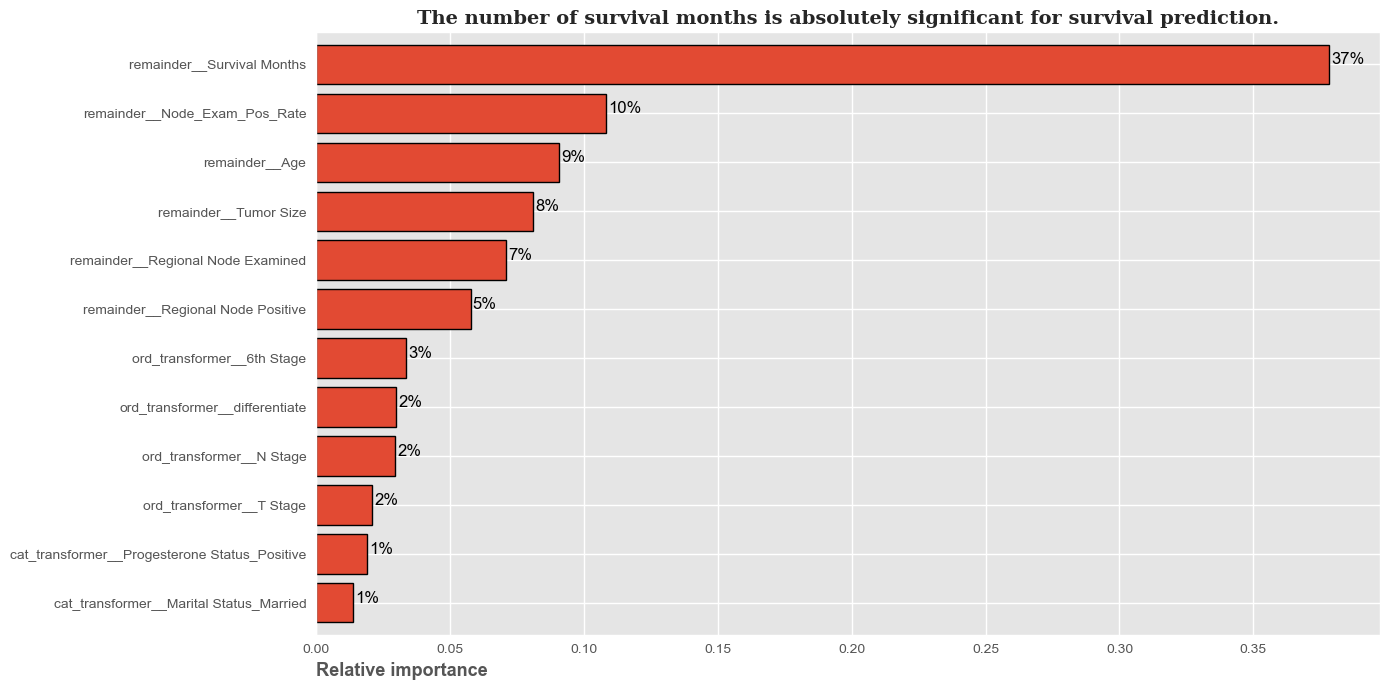

In [103]:
#plotting top 10 important features

fig, ax = plt.subplots(figsize=(14,7))

plt.style.use('ggplot')

feature_importance.sort_values(ascending=True).plot(kind='barh',
                         ax=ax, 
                         width=0.8,
                         legend=False,
                         linewidth=1, 
                         edgecolor='#000000')

ax.set_title(label="The number of survival months is absolutely significant for survival prediction.",
             family="serif",
             weight="semibold",
             size=14);

ax.set_xlabel(xlabel="Relative importance",
             position=[0,0],
             horizontalalignment="left",
             size=13,
             weight="semibold")

for idx in range(len(feature_importance)):
    ax.text(s='{}%'.format(int(feature_importance.sort_values(ascending=True).iloc[idx]*100)),
            x=feature_importance.sort_values(ascending=True).iloc[idx]+0.0008,
            y=idx,
            size=12,
            color="black")

fig.tight_layout()

In [104]:
from pdpbox import pdp

#calculate the partial dependence of the prediction on the Feature Tumor Size
pdp_Tumor_Size = pdp.PDPIsolate(model=model, 
                                df=features_train,
                                n_classes=2, 
                                model_features=features_train.columns,  
                                feature='Tumor Size',
                                feature_name='Tumor Size')



obtain pred_func from the provided model.


100%|██████████| 10/10 [00:00<00:00, 12.06it/s]


(<Figure size 4800x2700 with 2 Axes>,
 {'title_axes': <Axes: >,
  'line_axes': [<Axes: xlabel='$\\bf{Tumor Size}$ (value)', ylabel='centered'>],
  'dist_axes': []})

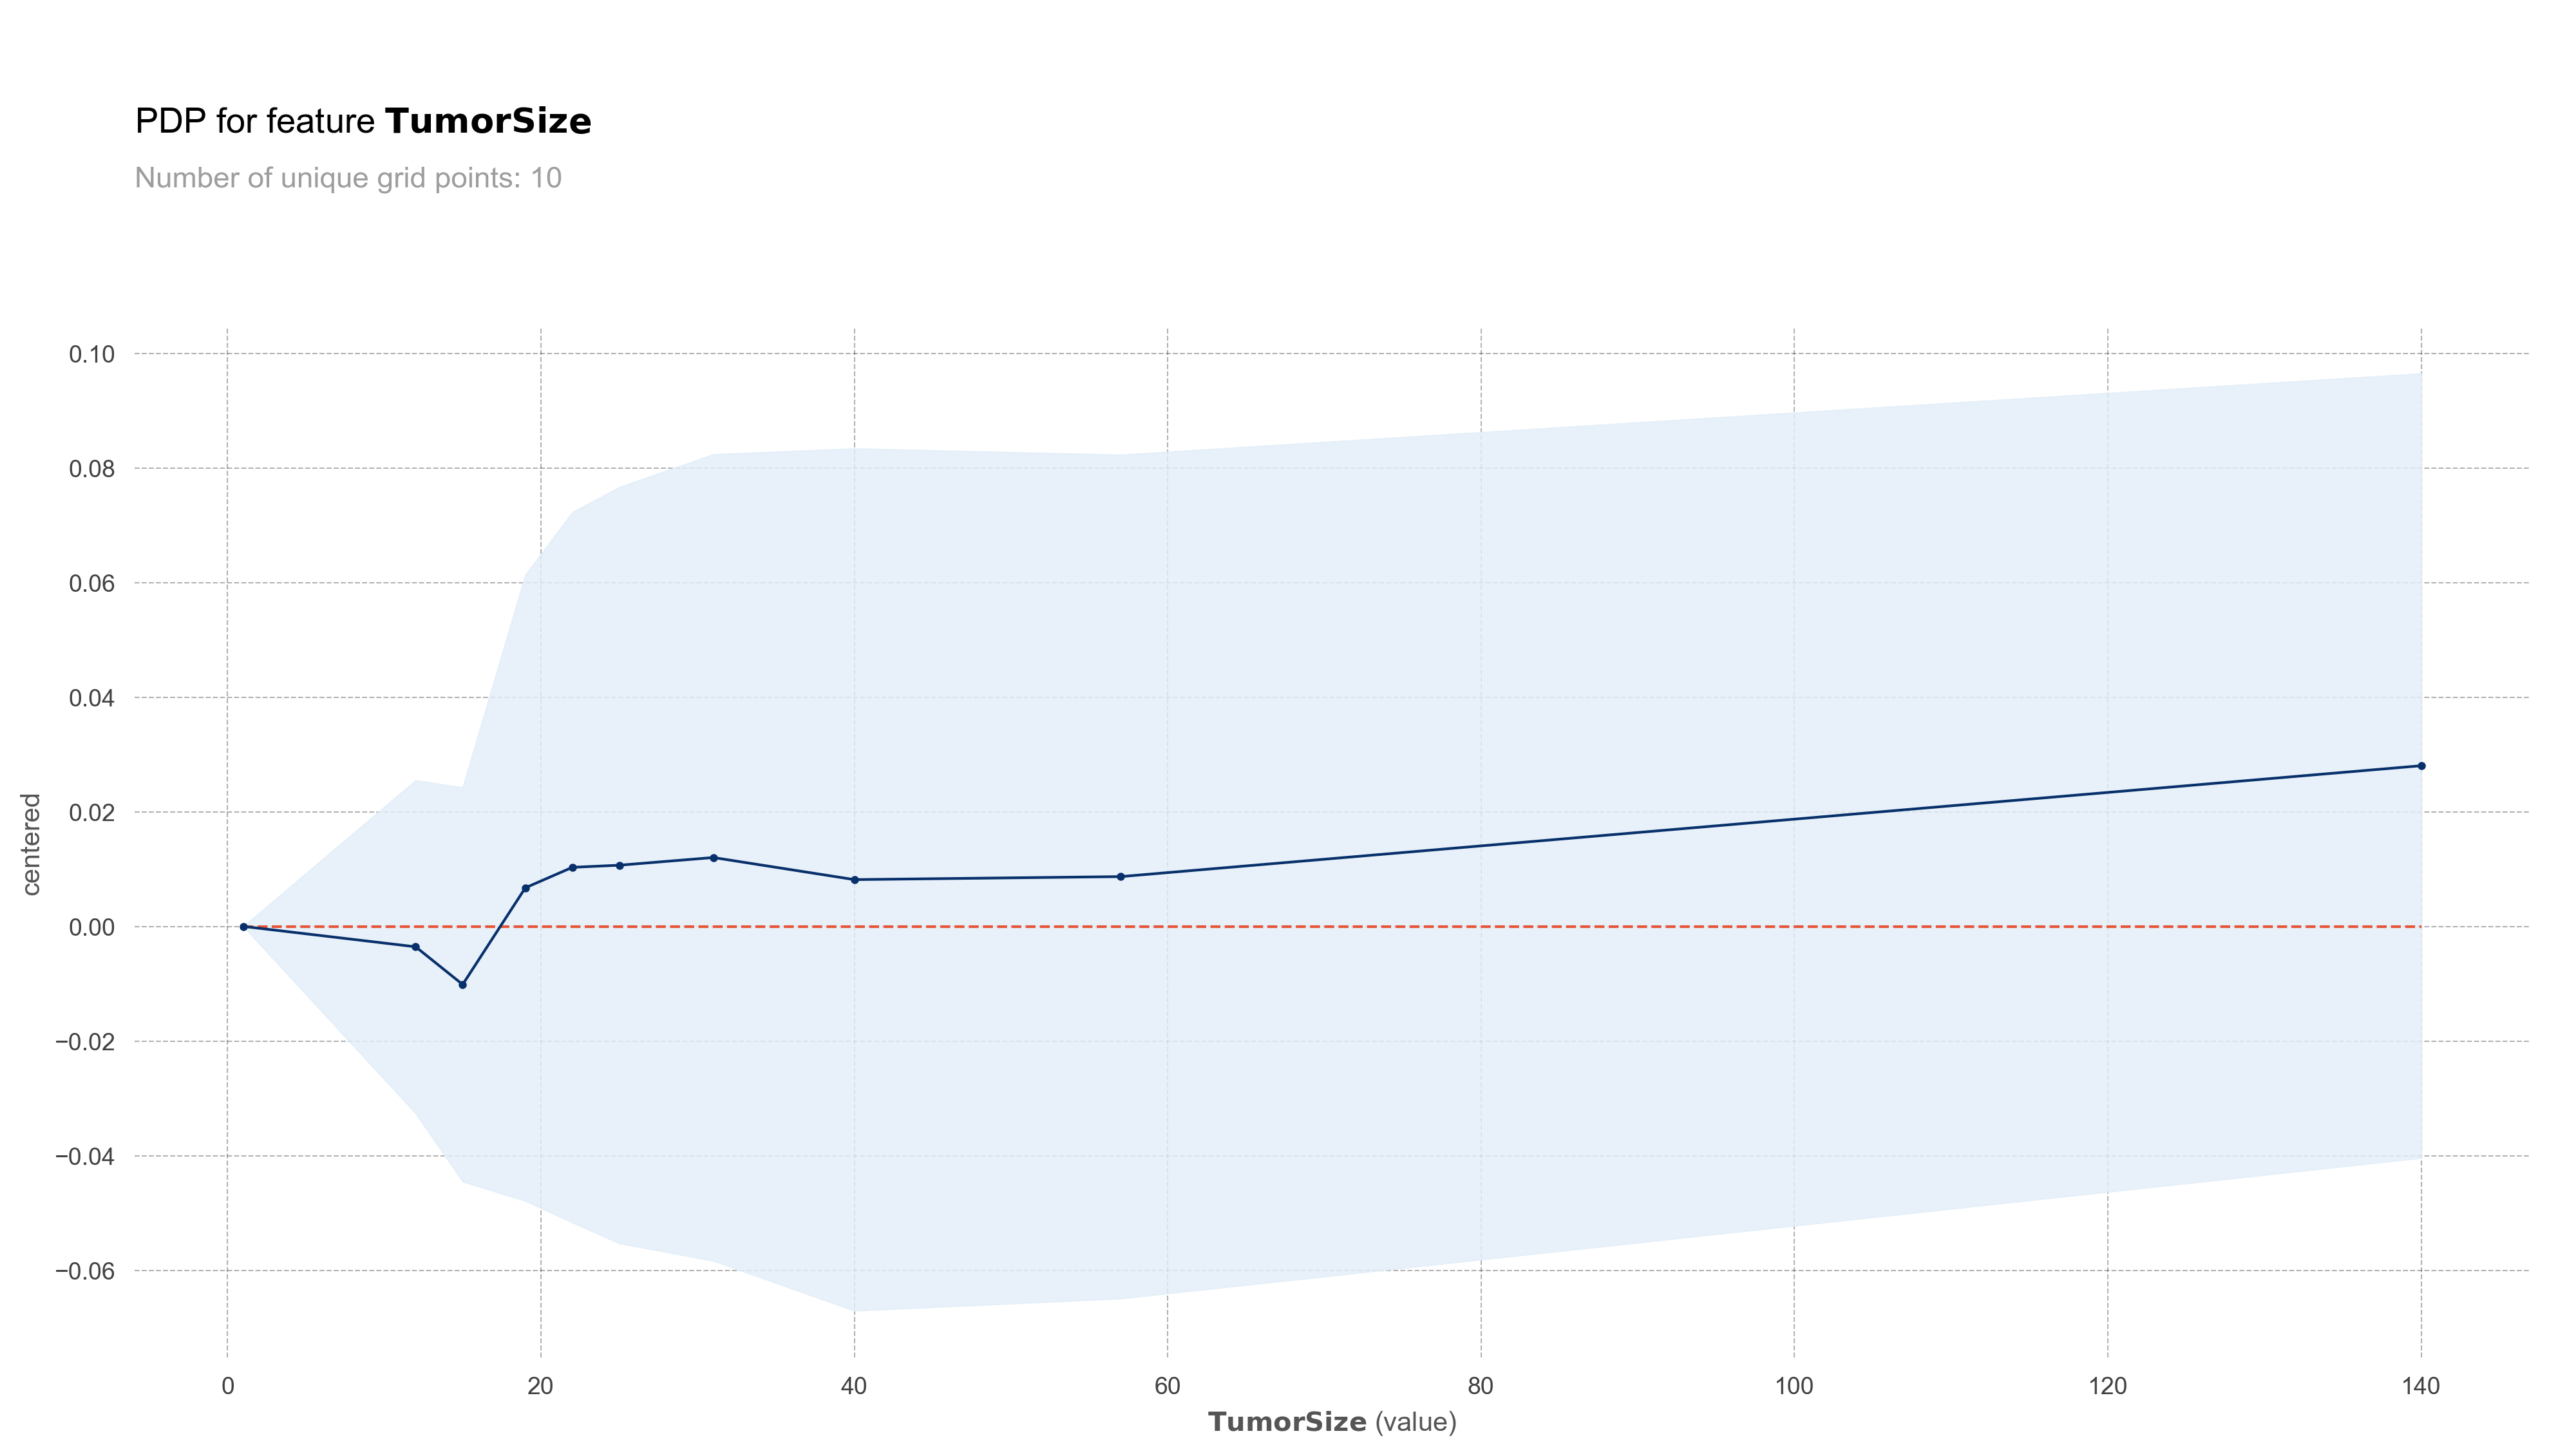

In [105]:
pdp_Tumor_Size.plot(engine='matplotlib')


In [106]:
from sklearn import inspection

pdp_Tumor_Size = inspection.partial_dependence(estimator=model, X=features_train, features='Tumor Size')

In [107]:
from sklearn.inspection import plot_partial_dependence

base_features = ['Survival Months',
                 'Age',
                 'Tumor Size']

for i in range(4):
    plot_partial_dependence(model, features_train, [i], base_features)

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (c:\Users\bmerg\anaconda3\envs\portfolio_minimal_ds\lib\site-packages\sklearn\inspection\__init__.py)

In [108]:
#calculate the partial dependence of the prediction on the Feature Node_Exam_Pos_Rate
pdp_Node_Exam_Pos_Rate = pdp.PDPIsolate(model=model, 
                                df=features_train,
                                n_classes=2, 
                                model_features=features_train.columns,  
                                feature='Node_Exam_Pos_Rate',
                                feature_name='Node_Exam_Pos_Rate')


obtain pred_func from the provided model.


100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


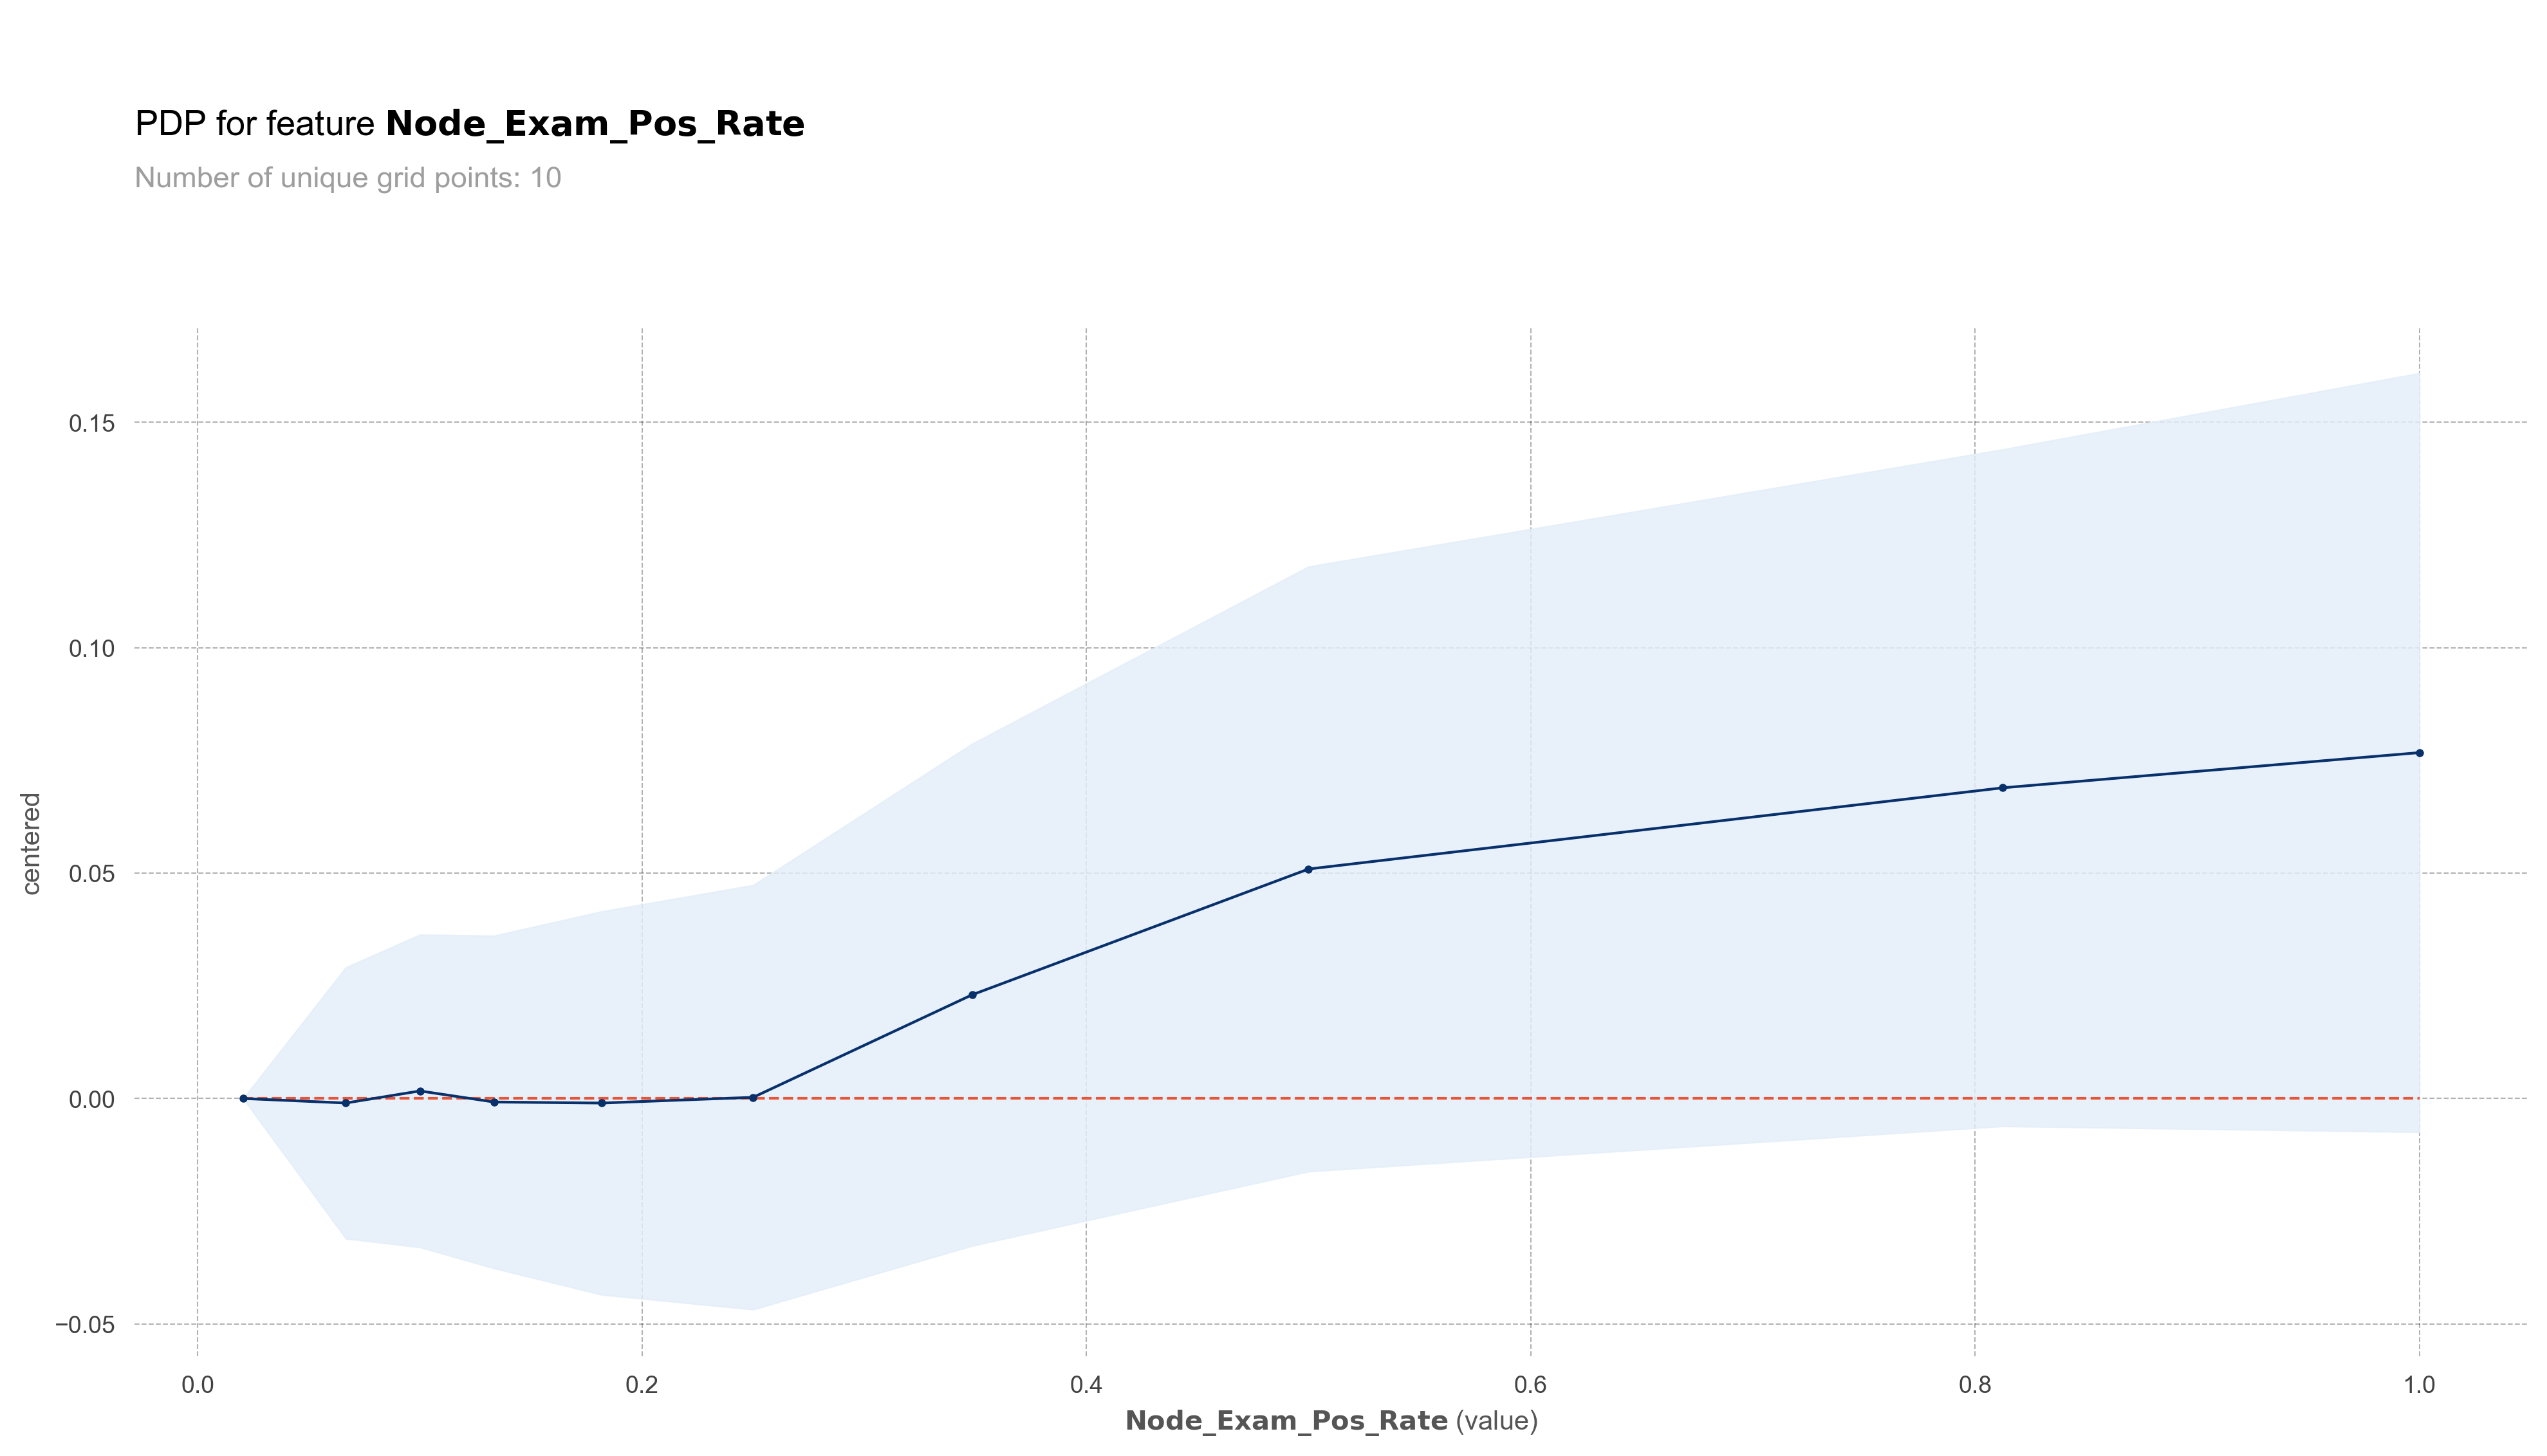

In [109]:
#visualie the pdartial dependence plot
pdp_Node_Exam_Pos_Rate.plot(engine='matplotlib');

In [110]:
#calculate the partial dependence of the prediction on the Feature Survival Months
pdp_Survival_Months = pdp.PDPIsolate(model=model, 
                                df=features_train,
                                n_classes=2, 
                                model_features=features_train.columns,  
                                feature='Survival Months',
                                feature_name='Survival Months')

obtain pred_func from the provided model.


100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


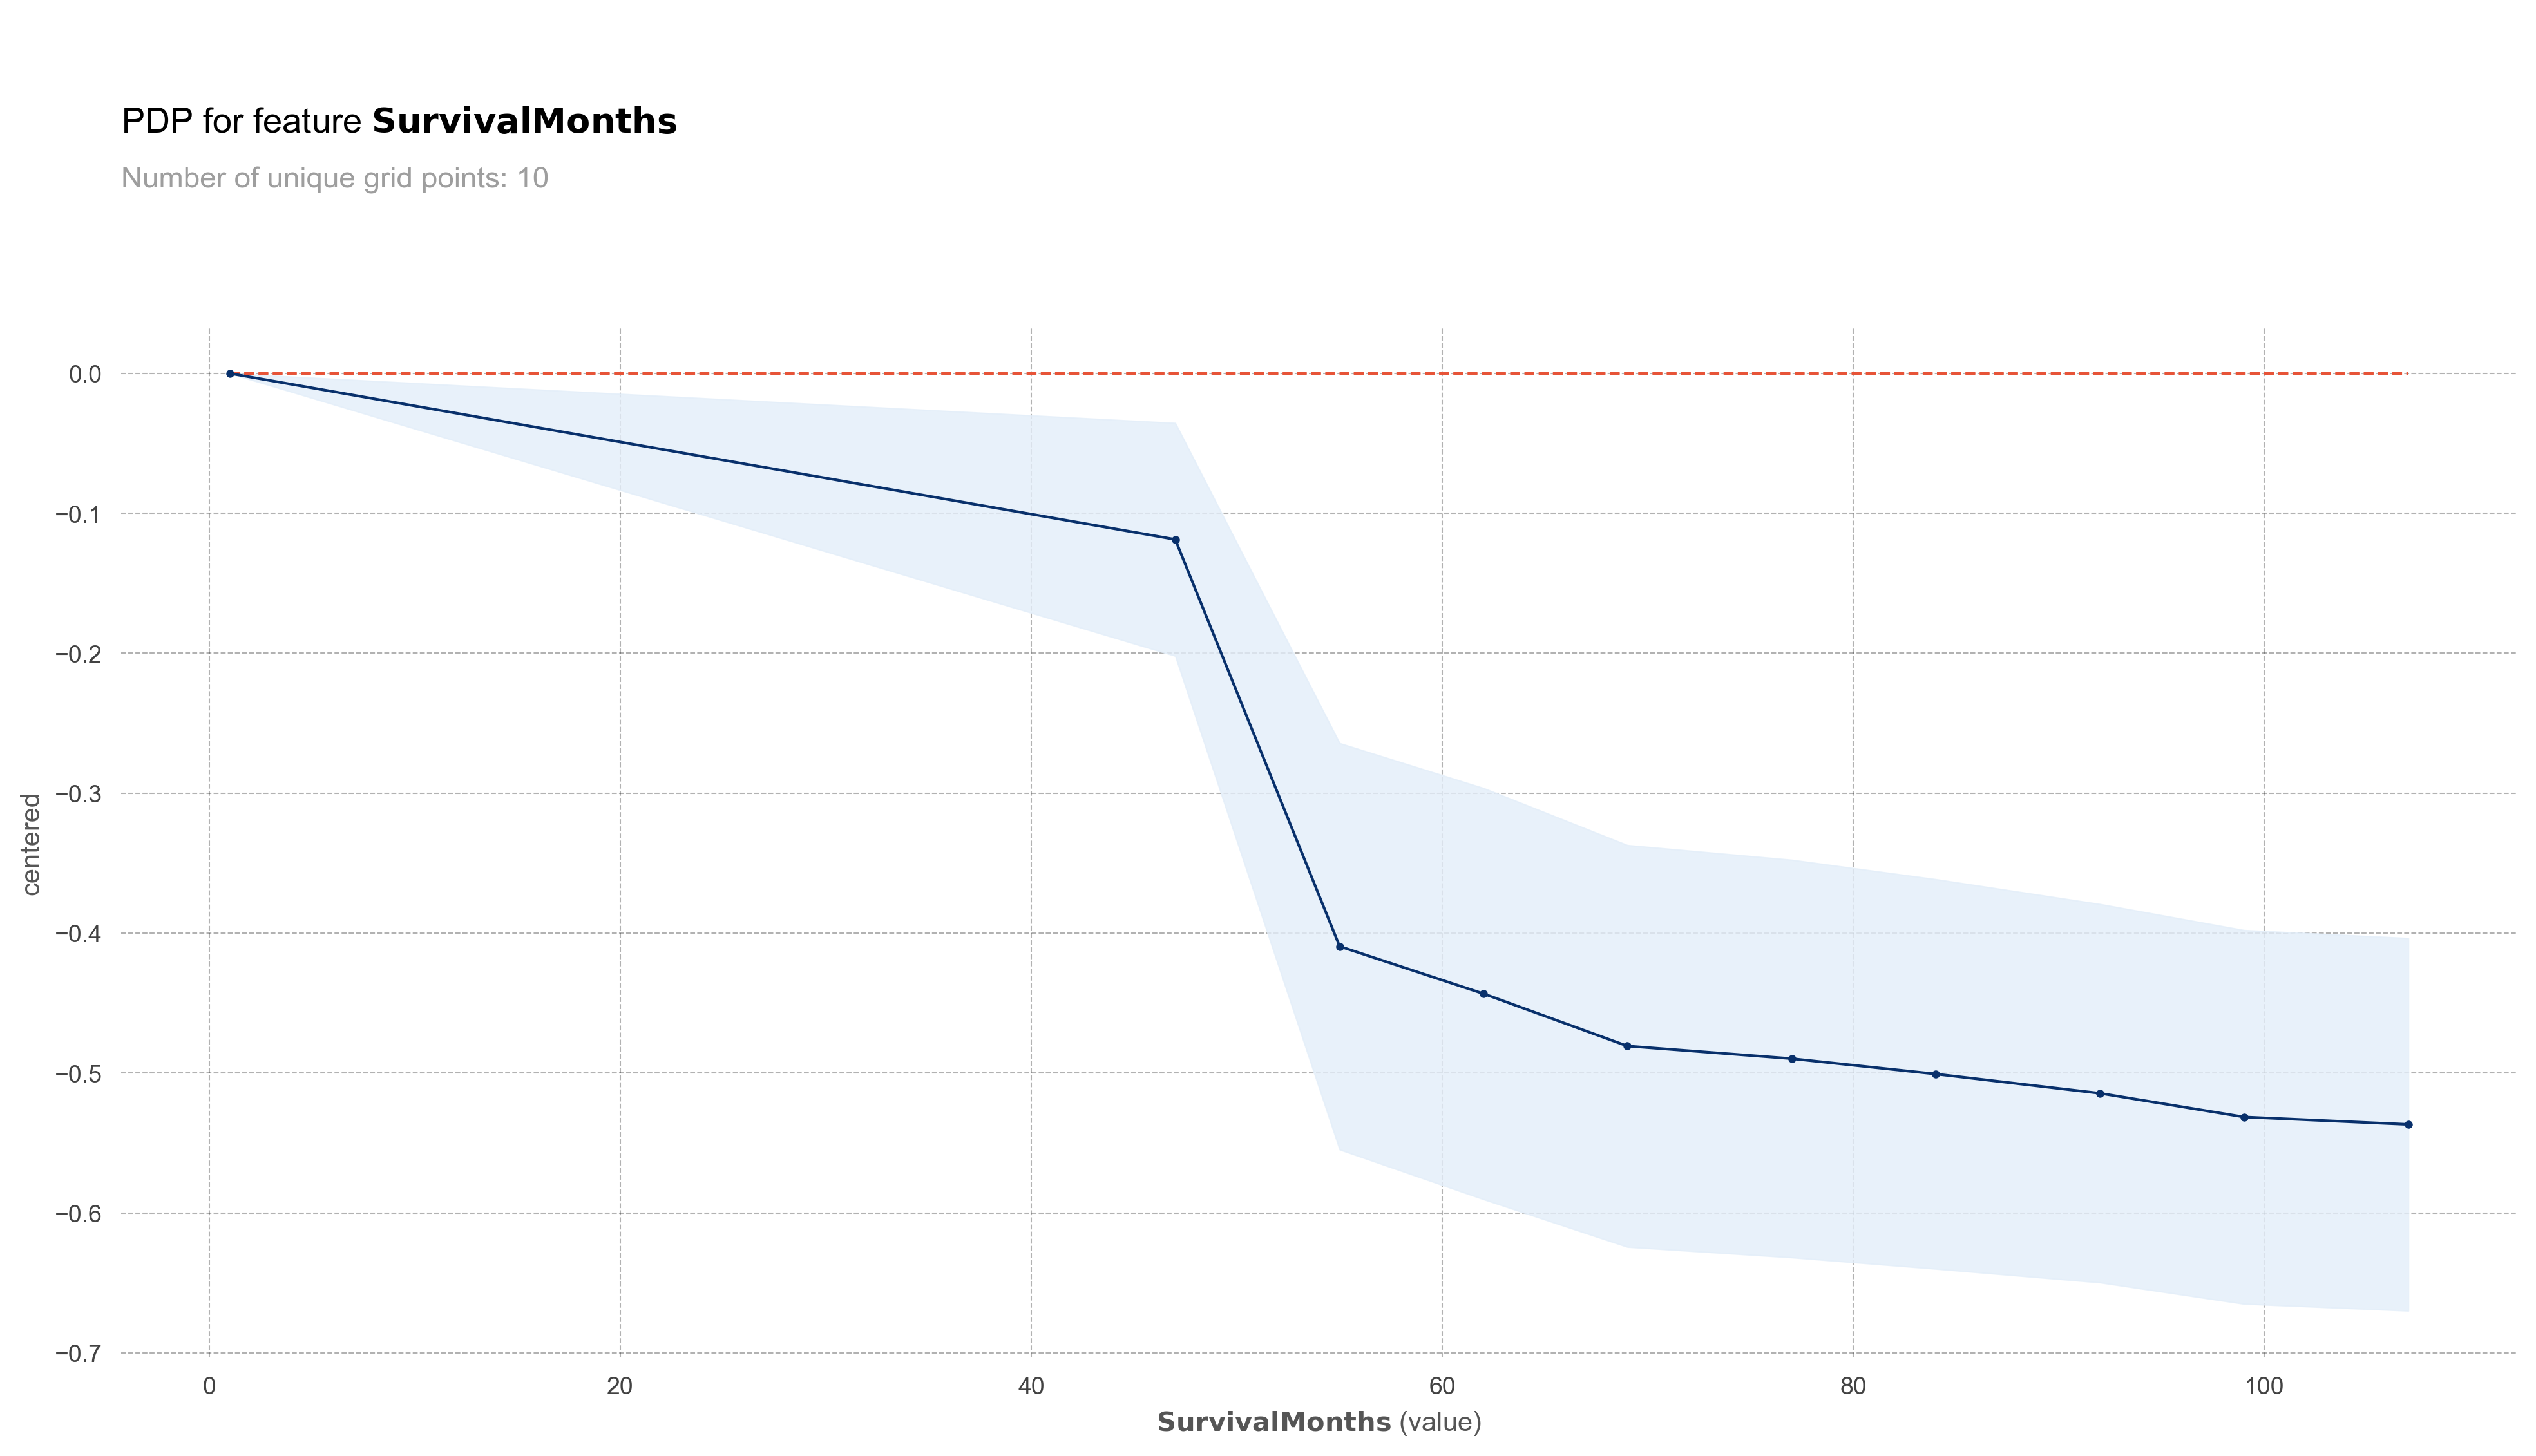

In [111]:
pdp_Survival_Months.plot(engine='matplotlib');

In [112]:
#calculate the partial dependence of the prediction on the Feature Regional Node Positive
pdp_Regional_Node_Positive = pdp.PDPIsolate(model=model, 
                                df=features_train,
                                n_classes=2, 
                                model_features=features_train.columns,  
                                feature='Regional Node Positive',
                                feature_name='Regional Node Positive')

obtain pred_func from the provided model.


100%|██████████| 6/6 [00:00<00:00,  8.27it/s]


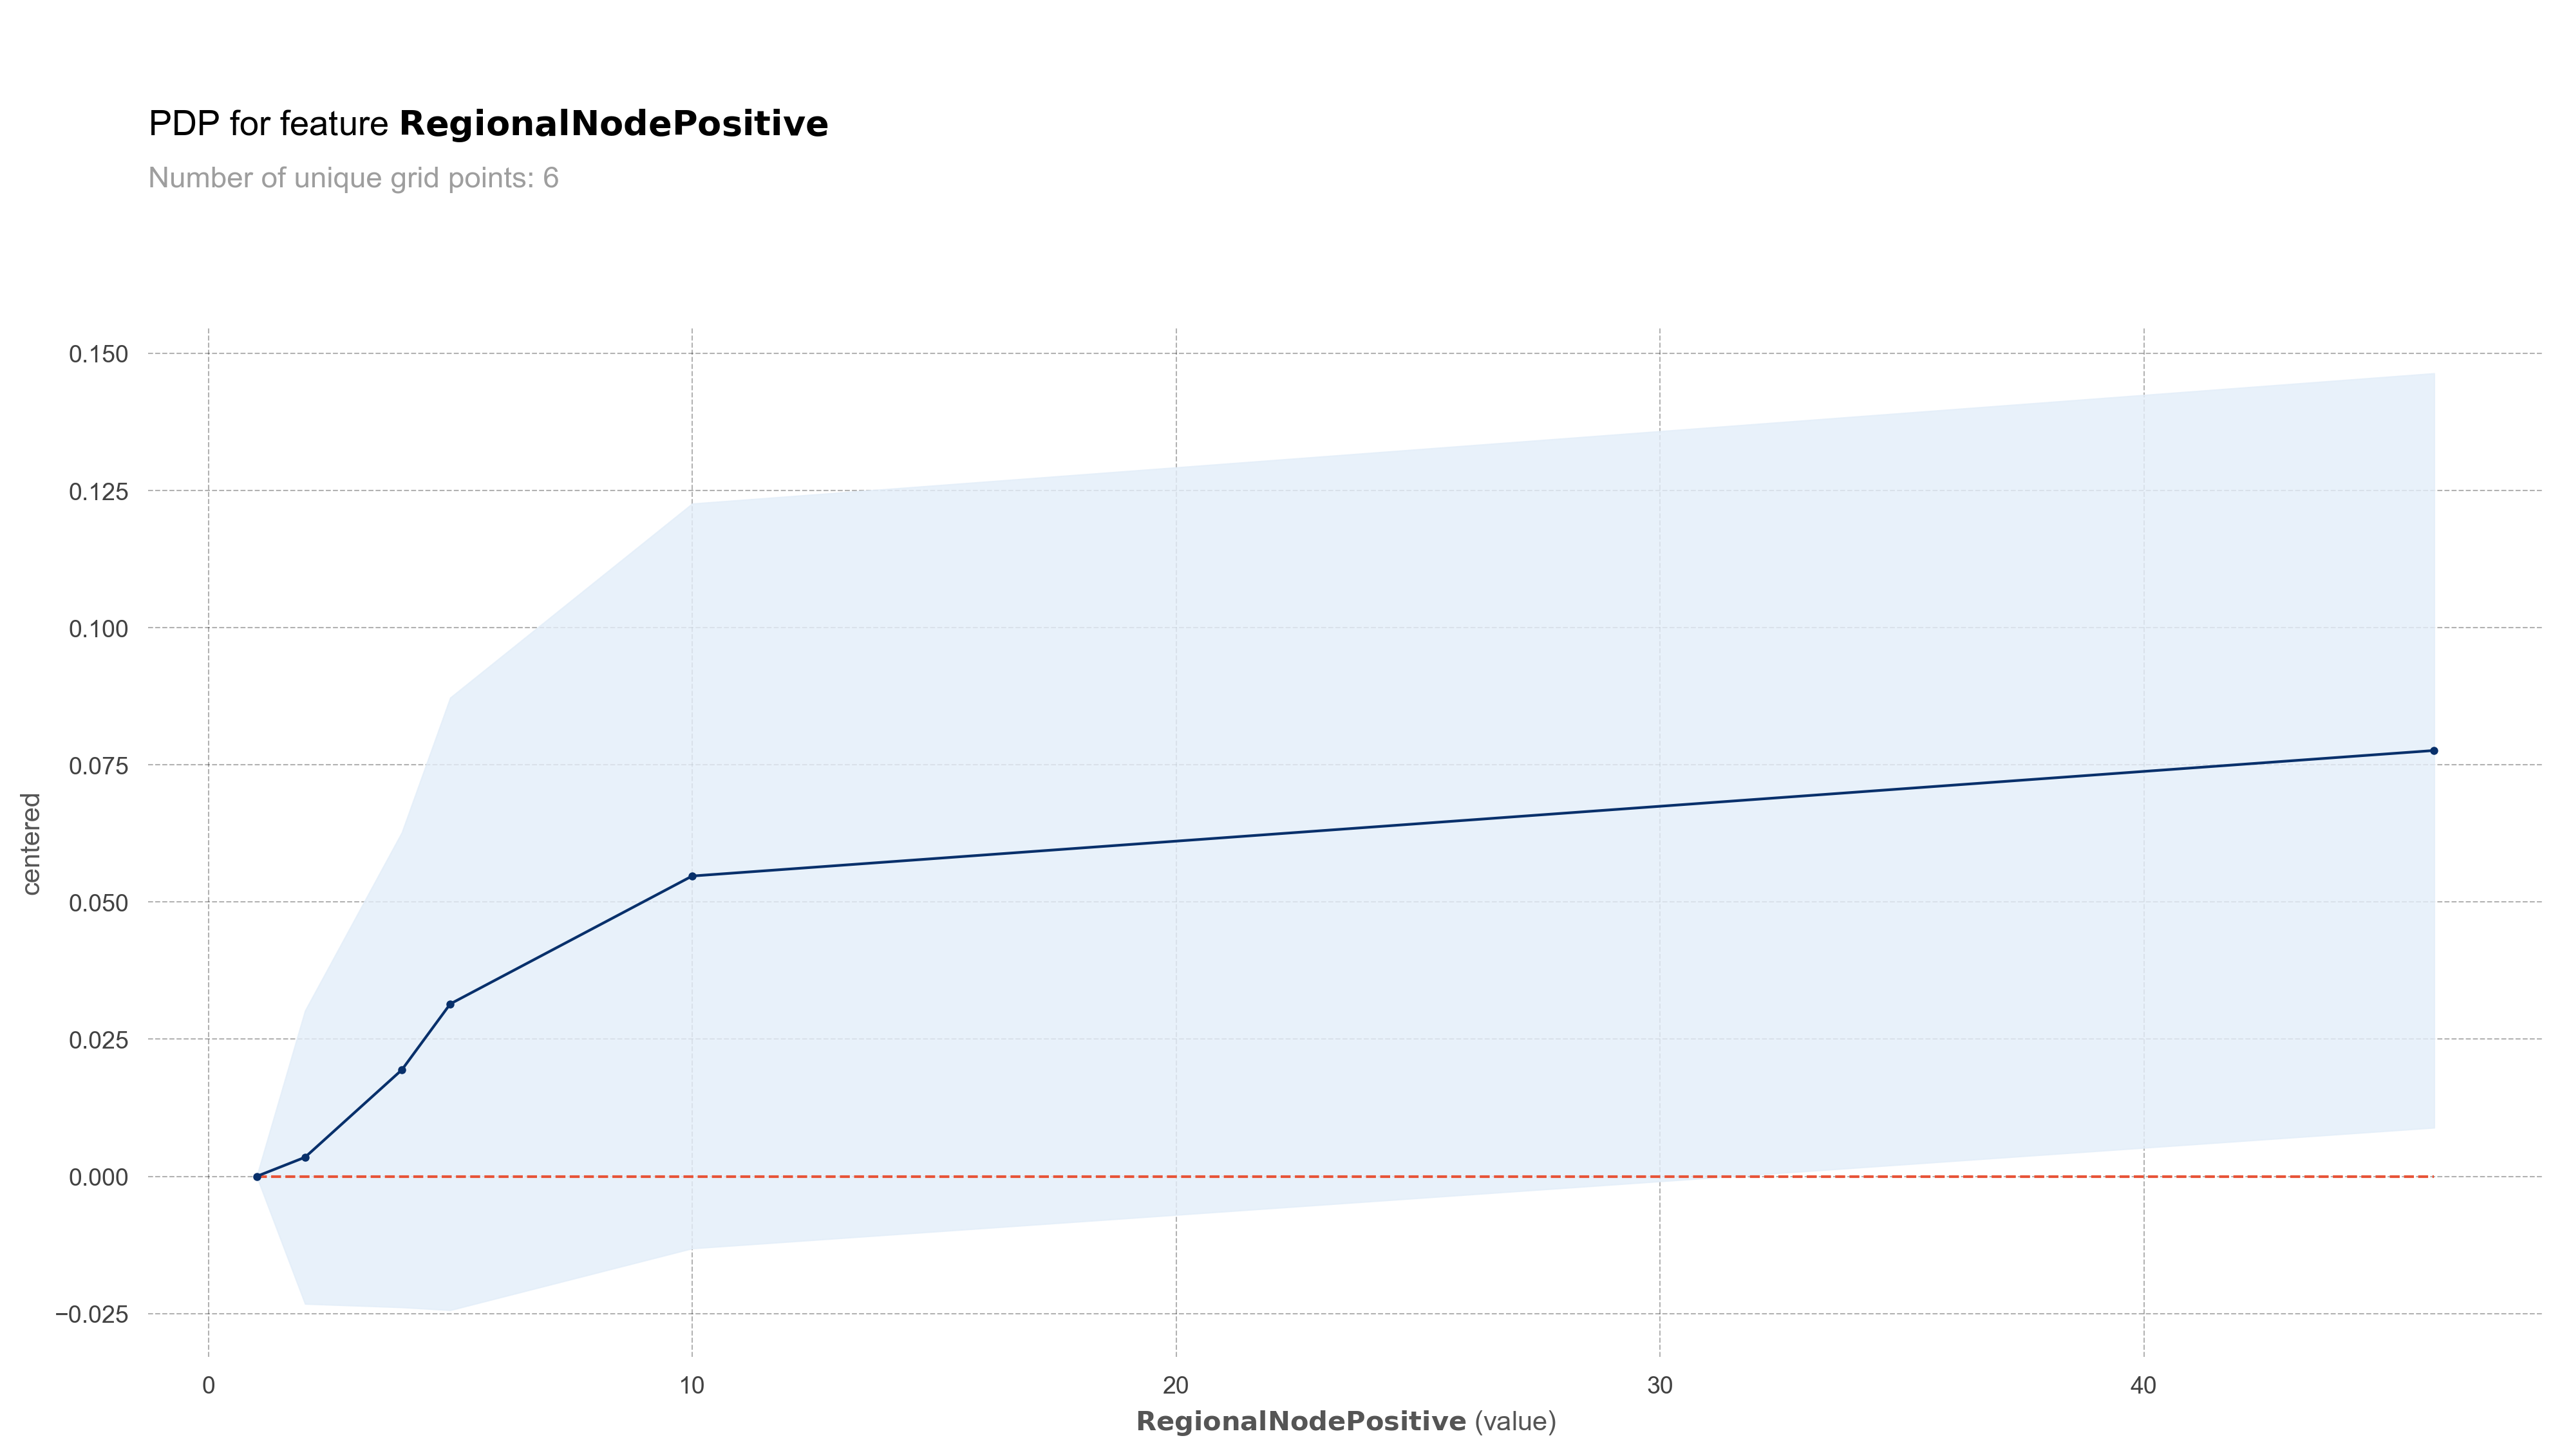

In [113]:
pdp_Regional_Node_Positive.plot(engine='matplotlib');